In [1]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Loading data

In [2]:
# import own scripts
import util.preprocess_data as prepData
import util.load_data as loadData
import util.modeling as modeling
import util.visualize_data as vizData

C:\Users\lpsze\anaconda3\envs\QB_hackathon\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# data handling
import os
import numpy as np
from PIL import Image

# data viz
import matplotlib.pyplot as plt

# modeling
import torch

# hyperparam optimization
from ray import tune

In [4]:
config = {
    # basic infos
    "dir": os.path.normpath(os.getcwd()).replace("\\", "/"),
    "verbose": True,
    "save": False,
    
    # k-fold cross val settings
    "artificial_test_size": 0.15,
    "k_cv": 5, # must be bigger than 1
    
    # test set settings
    "official_test": False,
    "batch_size": 16,
    
    # preprocessing
    "resize": True, # resize images from (64, 64) to (224, 224)
    "apply_CLAHE": False, # improve image contrast
}

In [5]:
# ensure reproducibility (for meaningful hyperparameter selection that does not depend on random seed behavior)
modeling.set_reproducible()

# initialise objects for training
_, _, tstloader = modeling.init_data(config)

# Predicting

In [6]:
import util.inference as inference
import util.modeling as modeling
import util.GradCam as GradCam
from tqdm import tqdm 

In [12]:
paths_to_images = tstloader.dataset.metadata.path.tolist()
y_true = tstloader.dataset.metadata.plume.tolist()  # True labels (0 or 1)
y_hat = []
best_models = []
y_pred_probs = []  # Predicted probabilities for class 1
path_to_models = "models/ensamble/" 
device = GradCam.get_device()

In [13]:
for path in tqdm(paths_to_images):
    prob, lbl, best_model = inference.infer_mobilenet(path_to_models=path_to_models, path_to_img=path, device=device)
    y_pred_probs.append(prob)
    y_hat.append(lbl)
    best_models.append(best_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:45<00:00,  1.41it/s]


# Plotting ROC

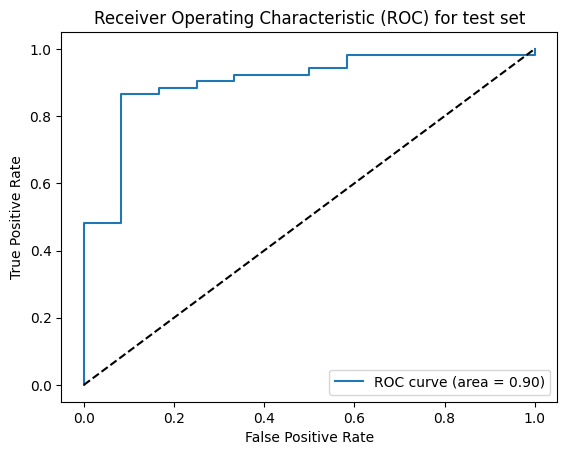

In [10]:
# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

# Compute the AUC score
auc_score = roc_auc_score(y_true, y_pred_probs)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for test set')
plt.legend(loc='lower right')
plt.show()

# Plotting models certanity

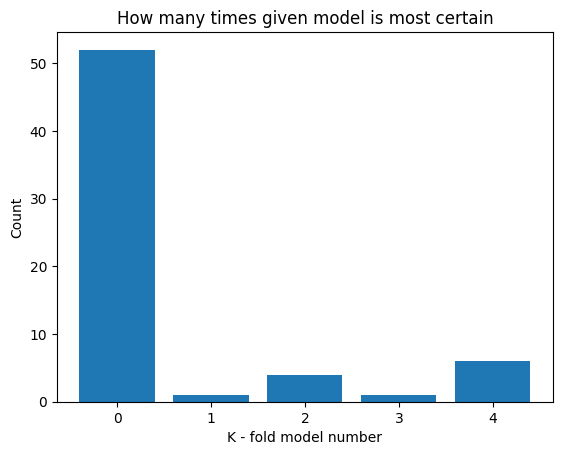

In [15]:
# Get unique values and their counts
unique_values, value_counts = np.unique(best_models, return_counts=True)

# Plotting the bar chart
plt.bar(unique_values, value_counts)

# Adding labels and title
plt.xlabel('K - fold model number')
plt.ylabel('Count')
plt.title('How many times given model is most certain')

# Display the chart
plt.show()

# Plotting distribiution of probas